# HBV hydrological model forced with ERA5 forcing data
In this notebook we will run the HBV model using the historical forcing data from ERA5 and CMIP6 we generated in earlier notebooks.

For a more basic explenation on how to run a model in eWaterCycle, see [this tutorial](https://www.ewatercycle.org/projects/main/tutorials_examples/1_HBV_Caravan_ERA5/example_model_run_HBV.html). 

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# Parameters
region_id = None
settings_path = "settings.json"

In [4]:
# Parameters
region_id = "camelsgb_22007"
settings_path = "regions/camelsgb_22007/settings.json"


In [5]:
# Load settings
# Read from the JSON file
with open(settings_path, "r") as json_file:
    settings = json.load(json_file)

In [6]:
display(settings)

{'caravan_id': 'camelsgb_22007',
 'calibration_start_date': '1994-08-01T00:00:00Z',
 'calibration_end_date': '2004-07-31T00:00:00Z',
 'validation_start_date': '2004-08-01T00:00:00Z',
 'validation_end_date': '2014-07-31T00:00:00Z',
 'future_start_date': '2029-08-01T00:00:00Z',
 'future_end_date': '2049-08-31T00:00:00Z',
 'CMIP_info': {'dataset': ['MPI-ESM1-2-HR'],
  'ensembles': ['r1i1p1f1'],
  'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
  'project': 'CMIP6',
  'frequency': 'day',
  'grid': 'gn',
  'variables': ['pr', 'tas', 'rsds']},
 'base_path': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV',
 'path_caravan': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/caravan',
 'path_ERA5': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/ERA5',
 'path_CMIP6': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/CMIP6',
 'path_output': '/

## load ERA5 forcing
See [this notebook](repos/ewatercycle-climatechangeimpact/step_1a_generate_historical_forcing.ipynb) on how the data loaded below was generated.

In [7]:
# This additional steo is needed because ERA5 forcing data is stored deep in a sub-directory
load_location = Path(settings['path_ERA5']) / "work" / "diagnostic" / "script" 
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [8]:
display(ERA5_forcing_object)

LumpedMakkinkForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/ERA5/work/diagnostic/script'), shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/ERA5/work/diagnostic/script/camelsgb_22007.shp'), filenames={'pr': 'OBS6_ERA5_reanaly_1_day_pr_1994-2014.nc', 'tas': 'OBS6_ERA5_reanaly_1_day_tas_1994-2014.nc', 'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1994-2014.nc', 'evspsblpot': 'Derived_Makkink_evspsblpot.nc'})

/scratch-local/mmelotto.17160729/ipykernel_3096414/1279259822.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
/scratch-local/mmelotto.17160729/ipykernel_3096414/1279259822.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.


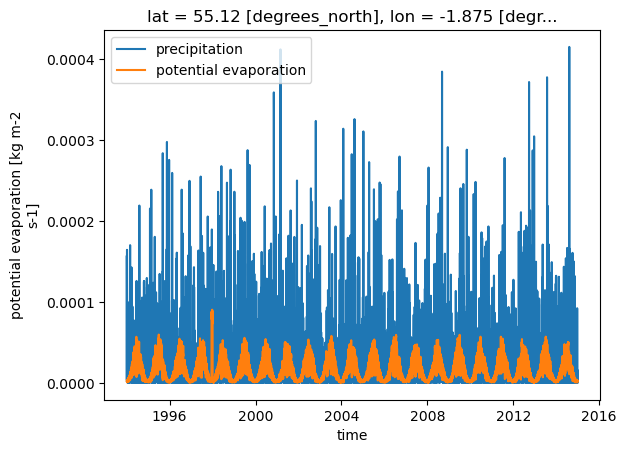

In [9]:
# Quick plot of the precipitation and potential evaporation data
ds_ERA5 = xr.open_mfdataset([ERA5_forcing_object['pr'],ERA5_forcing_object['evspsblpot']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## CMIP historical forcing

In [10]:
# because there can be multiple forcing datasets from CMIP historical 
# for different climate models and different ensemble members, we will
# create a dict of forcing objects
CMIP_forcing_object = dict()

for dataset in settings['CMIP_info']['dataset']:
    CMIP_forcing_object[dataset] = dict()
    for ensemble_member in settings['CMIP_info']['ensembles']:

        cmip_dataset = {
            "dataset": dataset,
            "project": settings['CMIP_info']['project'],
            "grid": "gn",
            "exp": "historical",
            "ensembles": ensemble_member,
        }
        
        # This is the subfolder for this specific combination of dataset, experiment and ensemblemember
        path_CMIP6 = Path(settings['path_CMIP6']) / cmip_dataset["dataset"] / cmip_dataset["exp"] / cmip_dataset["ensembles"]

        # This is needed because forcing data is stored deep in a sub-directory
        load_location = path_CMIP6 / "work" / "diagnostic" / "script" 
        CMIP_forcing_object[dataset][ensemble_member] = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)


    

In [11]:
#print the created object to check if everything is correct before running the model
display(CMIP_forcing_object)

{'MPI-ESM1-2-HR': {'r1i1p1f1': LumpedMakkinkForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/CMIP6/MPI-ESM1-2-HR/historical/r1i1p1f1/work/diagnostic/script'), shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/CMIP6/MPI-ESM1-2-HR/historical/r1i1p1f1/work/diagnostic/script/camelsgb_22007.shp'), filenames={'pr': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_pr_gn_1994-2014.nc', 'tas': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_tas_gn_1994-2014.nc', 'rsds': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_rsds_gn_1994-2014.nc', 'evspsblpot': 'Derived_Makkink_evspsblpot.nc'})}}

## Run models

We create a dict of all model runs we want to do. subsequently we run all of these in a single loop. This is chosen because this loop can be run in parallel if this gets scaled up.

In [12]:
# Load calibration constants from a csv file
par_0 = np.loadtxt(Path(settings["path_output"]) / (settings['caravan_id'] + "_params_SCE.csv"), delimiter = ",")

In [13]:
# Print parameter names and values
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
display(list(zip(param_names, np.round(par_0, decimals=3))))

[('Imax', 8.0),
 ('Ce', 0.78),
 ('Sumax', 40.0),
 ('Beta', 4.0),
 ('Pmax', 0.001),
 ('Tlag', 1.0),
 ('Kf', 0.1),
 ('Ks', 0.001),
 ('FM', 3.13)]

In [14]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [15]:
# Create model object, notice the forcing object.
models = dict()

for dataset in settings['CMIP_info']['dataset']:
    for ensemble_member in settings['CMIP_info']['ensembles']:
        models["CMIP6," + str(dataset) + "," +str(ensemble_member)] = ewatercycle.models.HBVLocal(forcing=CMIP_forcing_object[dataset][ensemble_member])

#add the ERA5 by hand
models["ERA5"] = ewatercycle.models.HBVLocal(forcing=ERA5_forcing_object)

display(models)

{'CMIP6,MPI-ESM1-2-HR,r1i1p1f1': HBVLocal(parameter_set=None, forcing=LumpedMakkinkForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/CMIP6/MPI-ESM1-2-HR/historical/r1i1p1f1/work/diagnostic/script'), shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/CMIP6/MPI-ESM1-2-HR/historical/r1i1p1f1/work/diagnostic/script/camelsgb_22007.shp'), filenames={'pr': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_pr_gn_1994-2014.nc', 'tas': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_tas_gn_1994-2014.nc', 'rsds': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_rsds_gn_1994-2014.nc', 'evspsblpot': 'Derived_Makkink_evspsblpot.nc'})),
 'ERA5': HBVLocal(parameter_set=None, forcing=LumpedMakkinkForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewater

In [16]:
model_output=dict()

In [17]:
for modelName, model in models.items():

    # Create config file in model.setup()
    config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
    # Initialize model
    model.initialize(config_file)
    # Run model, capture calculated discharge and timestamps
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
    # Finalize model (shuts down container, frees memory)
    model.finalize()

    # Make a pandas series
    model_output[modelName] = pd.Series(data=Q_m, name="modelled discharge, forcing: " + modelName, index=time)

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [18]:
caravan_data_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=settings['path_caravan'])

In [19]:
display(caravan_data_object)

CaravanForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/caravan'), shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22007/caravan/camelsgb_22007.shp'), filenames={'evspsblpot': 'camelsgb_22007_1994-08-01_2014-07-31_evspsblpot.nc', 'tasmin': 'camelsgb_22007_1994-08-01_2014-07-31_tasmin.nc', 'Q': 'camelsgb_22007_1994-08-01_2014-07-31_Q.nc', 'tas': 'camelsgb_22007_1994-08-01_2014-07-31_tas.nc', 'tasmax': 'camelsgb_22007_1994-08-01_2014-07-31_tasmax.nc', 'pr': 'camelsgb_22007_1994-08-01_2014-07-31_pr.nc'})

In [20]:
# Load the observations from the caravan object
caravan_discharge_observation = xr.open_mfdataset([caravan_data_object['Q']])
caravan_discharge_observation = caravan_discharge_observation.rename_vars({'Q':'observed Q Caravan'})
display(caravan_discharge_observation)

<xarray.Dataset> Size: 88kB
Dimensions:             (date: 7305)
Coordinates:
  * date                (date) datetime64[ns] 58kB 1994-08-01 ... 2014-07-31
Data variables:
    observed Q Caravan  (date) float32 29kB dask.array<chunksize=(7305,), meta=np.ndarray>

In [21]:
# We want to also be able to use the output of this model run in different analyses. Therefore, we save it as a NetCDF file.
xr_model_output = xr.merge([model_output_per_model.to_xarray() for name, model_output_per_model in model_output.items()])
xr_model_output = xr_model_output.rename({'index': 'time'})
xr_model_output.attrs['units'] = 'mm/d'
display(xr_model_output)


<xarray.Dataset> Size: 184kB
Dimensions:                                                    (time: 7669)
Coordinates:
  * time                                                       (time) datetime64[ns] 61kB ...
Data variables:
    modelled discharge, forcing: CMIP6,MPI-ESM1-2-HR,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: ERA5                          (time) float64 61kB ...
Attributes:
    units:    mm/d

In [22]:
# Testing things
display(xr_model_output)
display(caravan_discharge_observation)


<xarray.Dataset> Size: 184kB
Dimensions:                                                    (time: 7669)
Coordinates:
  * time                                                       (time) datetime64[ns] 61kB ...
Data variables:
    modelled discharge, forcing: CMIP6,MPI-ESM1-2-HR,r1i1p1f1  (time) float64 61kB ...
    modelled discharge, forcing: ERA5                          (time) float64 61kB ...
Attributes:
    units:    mm/d

<xarray.Dataset> Size: 88kB
Dimensions:             (date: 7305)
Coordinates:
  * date                (date) datetime64[ns] 58kB 1994-08-01 ... 2014-07-31
Data variables:
    observed Q Caravan  (date) float32 29kB dask.array<chunksize=(7305,), meta=np.ndarray>

In [23]:
ds = caravan_discharge_observation

if "date" in ds.coords or "date" in ds:
    # extract date values
    date_values = ds["date"].values

    # convert to datetime if needed
    try:
        time_values = pd.to_datetime(date_values)
    except Exception:
        raise ValueError("Could not convert `date` to datetime64.")

    # assign new time coordinate and swap dimensions
    ds = ds.assign_coords(time=("date", time_values))

    # If date is a dimension, swap it out
    if "date" in ds.dims:
        ds = ds.swap_dims({"date": "time"})

    # optionally drop the old date variable
    ds = ds.drop_vars("date")

caravan_discharge_observation = ds


In [24]:
display(caravan_discharge_observation.time)

<xarray.DataArray 'time' (time: 7305)> Size: 58kB
array(['1994-08-01T00:00:00.000000000', '1994-08-02T00:00:00.000000000',
       '1994-08-03T00:00:00.000000000', ..., '2014-07-29T00:00:00.000000000',
       '2014-07-30T00:00:00.000000000', '2014-07-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 58kB 1994-08-01 1994-08-02 ... 2014-07-31

In [25]:
# Interpolate model data to match the timestamps of the observations
xr_model_output_interp = xr_model_output.interp(time=caravan_discharge_observation.time)

# Merge the interpolated model output with observations
xr_merged = xr.merge([xr_model_output_interp, caravan_discharge_observation[['observed Q Caravan']]])

display(xr_merged)


<xarray.Dataset> Size: 205kB
Dimensions:                                                    (time: 7305)
Coordinates:
  * time                                                       (time) datetime64[ns] 58kB ...
Data variables:
    modelled discharge, forcing: CMIP6,MPI-ESM1-2-HR,r1i1p1f1  (time) float64 58kB ...
    modelled discharge, forcing: ERA5                          (time) float64 58kB ...
    observed Q Caravan                                         (time) float32 29kB dask.array<chunksize=(7305,), meta=np.ndarray>
Attributes:
    units:    mm/d

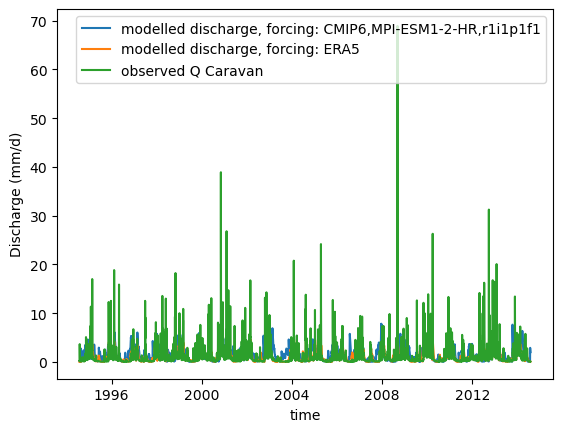

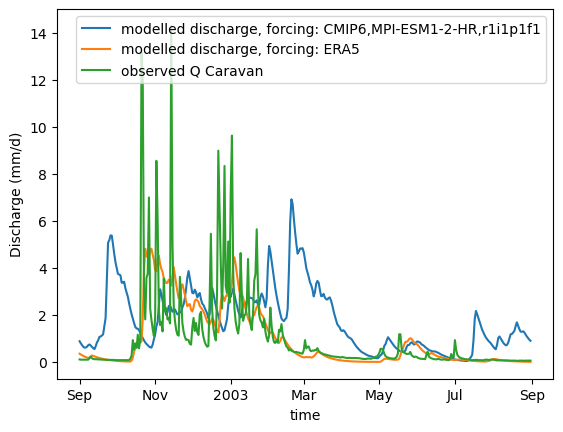

In [26]:
def plot_hydrograph(data_array):
    plt.figure()
    for name, da in data_array.data_vars.items():
        data_array[name].plot(label = name)
    plt.ylabel("Discharge (mm/d)")
    plt.legend()


xr_one_year = xr_merged.sel(time=slice('2002-09-01', '2003-08-31'))

plot_hydrograph(xr_merged)
plot_hydrograph(xr_one_year)

In [27]:
# Save the xarray Dataset to a NetCDF file
xr_merged.to_netcdf(Path(settings['path_output']) / (settings['caravan_id'] + '_historic_output.nc'))